In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

import torch
from   torch.utils import data
from data.data_utils import Dataset

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compare Rot MNIST results

### load data

In [3]:
data_path_test = 'data/rot_mnist/rot_mnist-te-data.pkl'
data_path_train = 'data/rot_mnist/rot_mnist-tr-data.pkl'
Ntrain = 500
Nvalid = 60
device = 'cpu'
dtype = torch.float64
batch_size = 20
shuffle = True
num_workers = 0

In [4]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)
X_tr = torch.load(data_path_train)
X_tr = X_tr.to(device).to(dtype)


In [5]:
params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(X_tr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [6]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive

In [7]:
T_in = 1
T_inv = 16
ode_latent_dim = 10
inv_latent_dim = 16
order = 1 
D_in  = ode_latent_dim
D_out = int(D_in/ order)
solver = 'euler'
use_adjoint = False
frames = 5
dt = 0.1
aug = False
Nobj = 1
task ='rot_mnist'
n_filt = 16
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'cnn'
last_layer_gp  = None

In [8]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [9]:
node_inv_contr.to(device)
fname = 'results/rot_mnist/20_01_2023-15:23/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### Node + inv 

In [10]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [11]:
node_inv.to(device)
fname = 'results/rot_mnist/20_01_2023-15:25/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### Node 

In [12]:
T_in = 5
inv_latent_dim=0
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [13]:
node_base.to(device)
fname = 'results/rot_mnist/21_01_2023-11:30/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(5, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### plot results

In [14]:
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()

In [15]:
from model.misc.plot_utils import plot_mnist, plot_latent_traj

In [16]:
X_te_index = [0,3,8,9,17]

In [ ]:
plot_mnist(X_te[0:20], X_te[0:20], show=True, N=20)

In [24]:
plotL= 16
forecast_te = 2
subsample = 4


##### Node+ inv +cont

In [38]:
Xrec_te_our, ztL_te, _, _, C_full = node_inv_contr(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

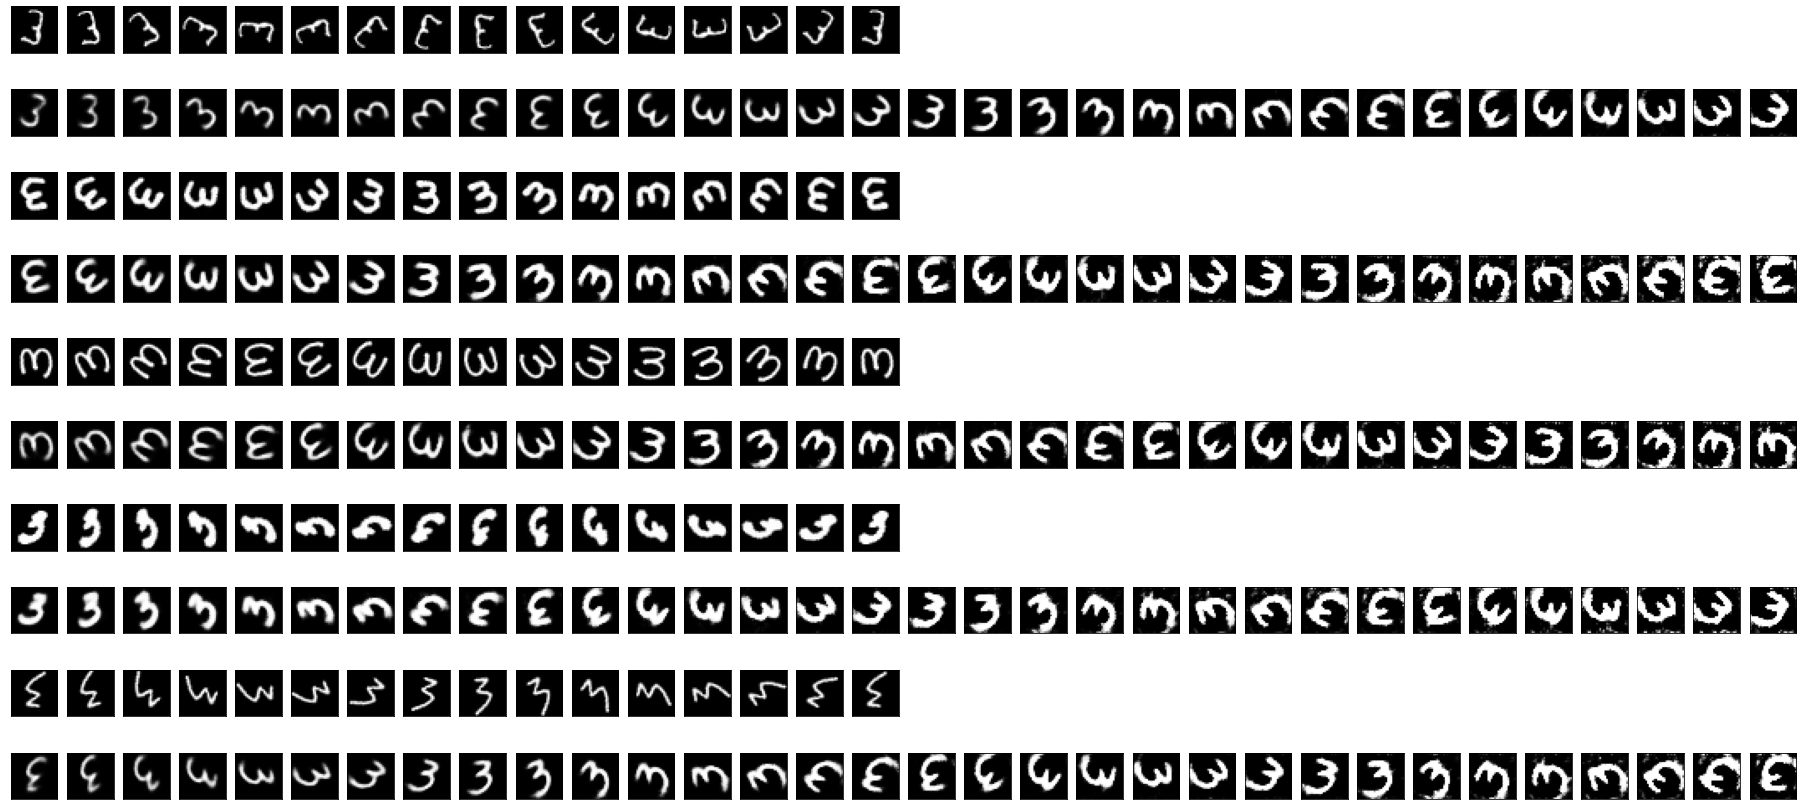

In [39]:
plot_mnist(X_te[X_te_index], Xrec_te_our, show=True)

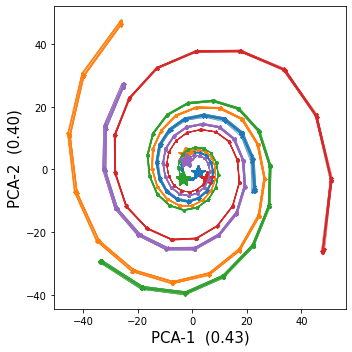

In [42]:
plot_latent_traj(ztL_te, show=True, Nplot=5)

##### Node+ inv

In [43]:
Xrec_te_inv, ztL_te, _, _, C_inv = node_inv(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

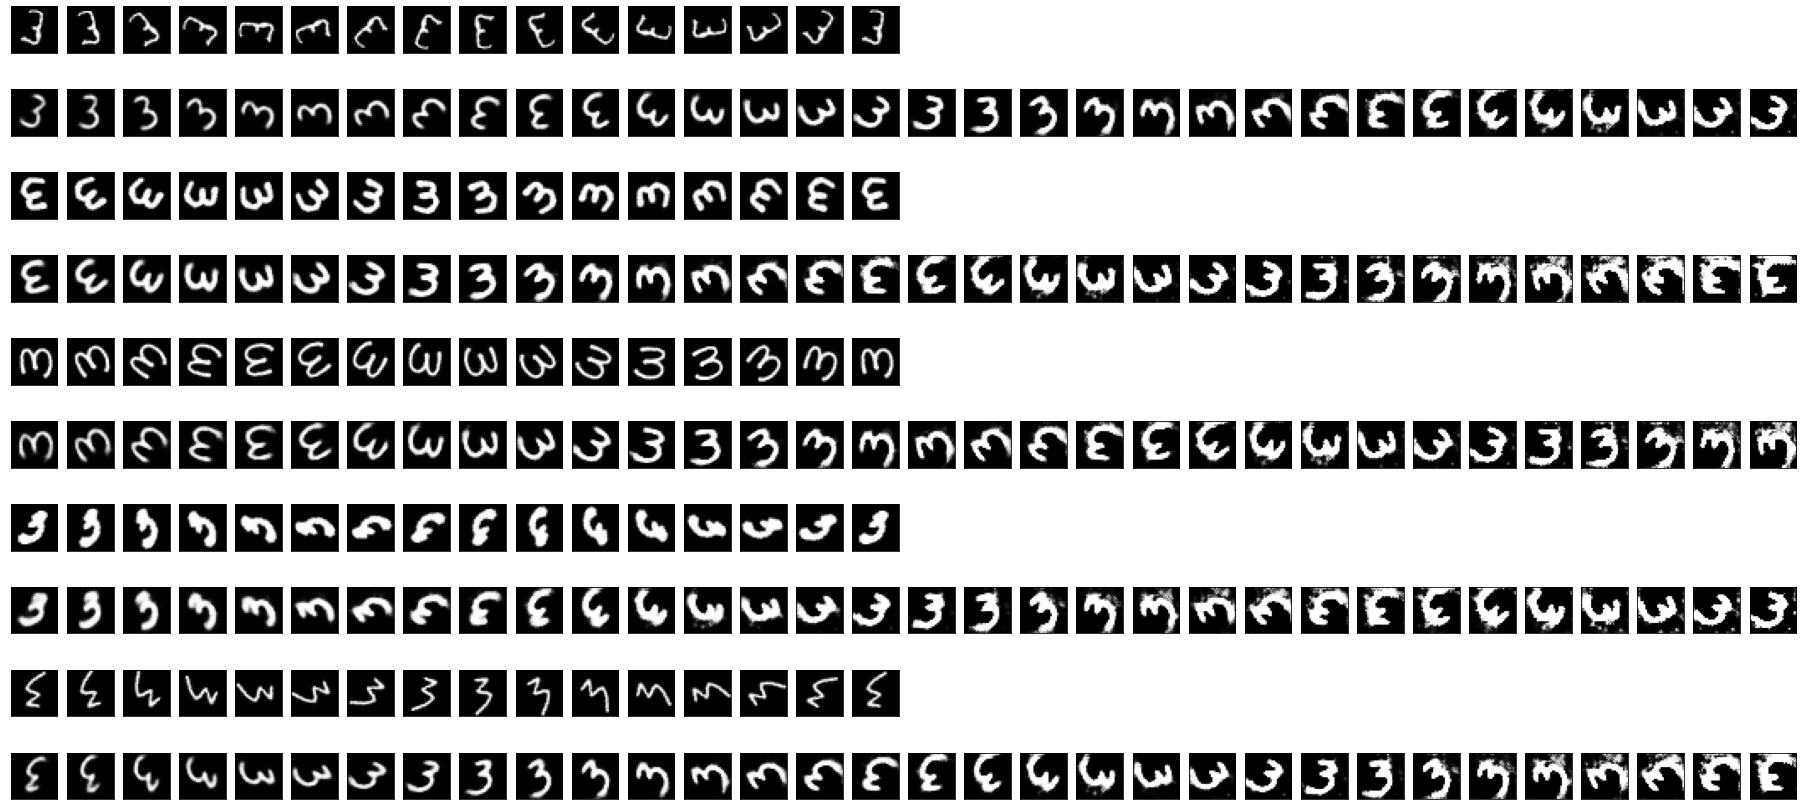

In [44]:
plot_mnist(X_te[X_te_index], Xrec_te_inv, show=True)

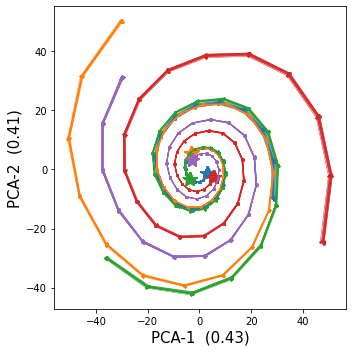

In [45]:
plot_latent_traj(ztL_te, show=True, Nplot=5)

##### Node 

In [46]:
Xrec_te_base, ztL_te, _, _, C_base = node_base(X_te[X_te_index],   L=plotL, T_custom=forecast_te*X_te.shape[1])

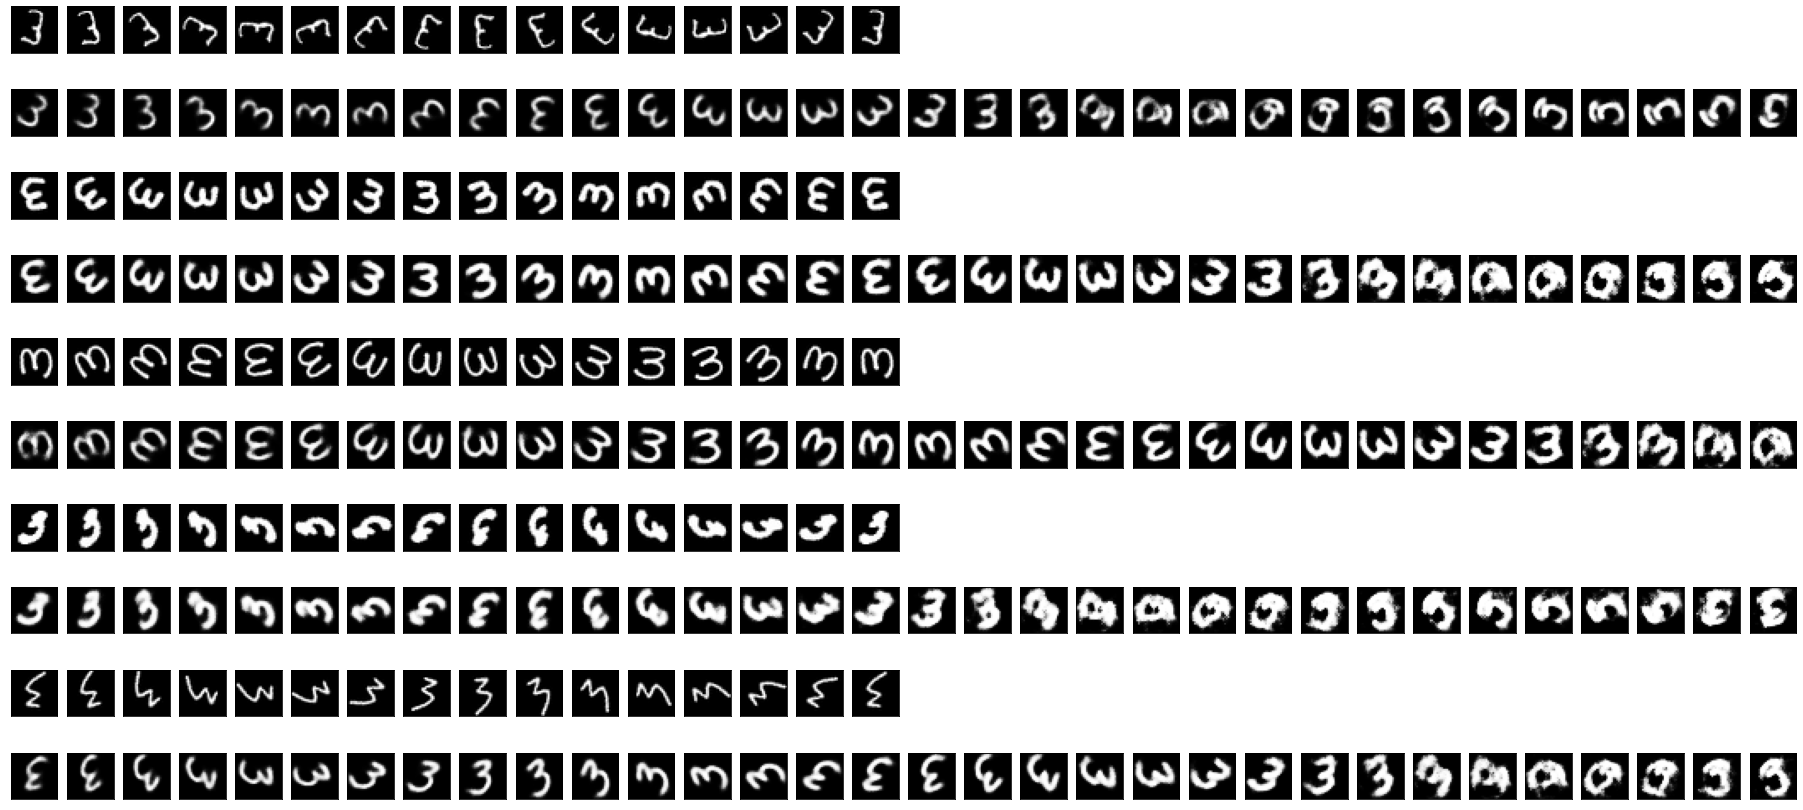

In [47]:
plot_mnist(X_te[X_te_index], Xrec_te_base, show=True)

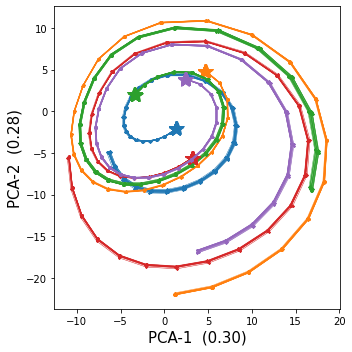

In [48]:
plot_latent_traj(ztL_te, show=True, Nplot=5)

Plot all in one

In [152]:
def plot_mnist_all(X, Xrec_contr, Xrec_inv, Xrec_base, show=False, fname='predictions.png', N=5):
    if (Xrec_contr.ndim > X.ndim) or (Xrec_inv.ndim > X.ndim) or (Xrec_base.ndim > X.ndim):
        Xrec_contr = Xrec_contr[0]
        Xrec_inv = Xrec_inv[0]
        Xrec_base = Xrec_base[0]
    if N is None:
        N = min(X.shape[0],10)

    Xnp    = X.detach().cpu().numpy()
    Xrecnp_c = Xrec_contr.detach().cpu().numpy()
    Xrecnp_i = Xrec_inv.detach().cpu().numpy()
    Xrecnp_b = Xrec_base.detach().cpu().numpy()

    Tdata  = X.shape[1]
    Tpred  = Xrec_contr.shape[1]
    T = max(Tpred,Tdata)
    c = Xnp.shape[-1]
    
    plt.figure(2,(T,4*N)) #3*
    for i in range(N): #0
        for t in range(Tdata): #16
            plt.subplot(4*N,Tpred,i*Tpred*4+t+1) #N*2 for 32 
            plt.imshow(np.reshape(Xnp[i,t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred+1)
            plt.imshow(np.reshape(Xrecnp_c[i,t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred*2+1)
            plt.imshow(np.reshape(Xrecnp_i[i,t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(Tpred):
            plt.subplot(4*N,Tpred,i*Tpred*4+t+Tpred*3+1)
            plt.imshow(np.reshape(Xrecnp_b[i,t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

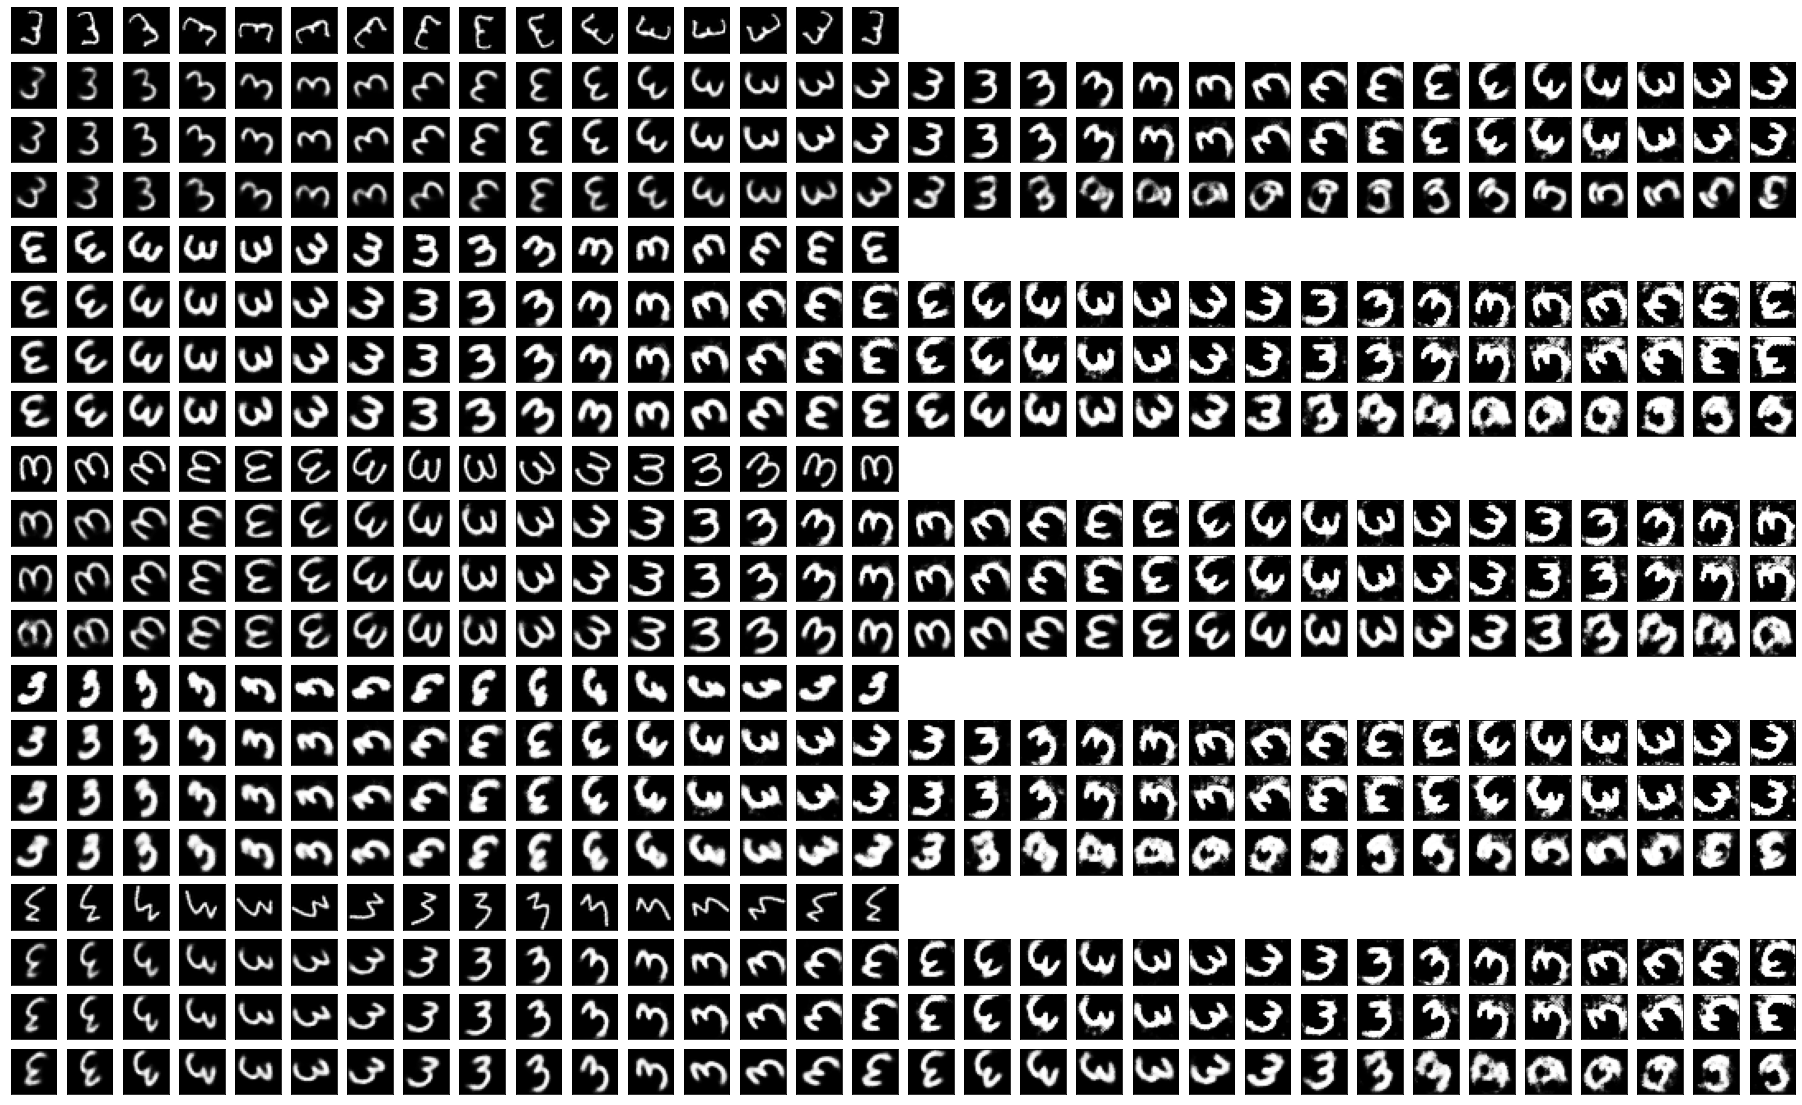

In [153]:
plot_mnist_all(X_te[X_te_index],Xrec_te_our, Xrec_te_inv, Xrec_te_base, show=True)

Test MSE

In [17]:
def compute_mse(model, dataset, T_inv=15, T=30, T_forecast=75, L=5, Eps=5): 
    T_set = [T_inv, T, T_forecast]
    dict_mse = {str(T):(None,None) for T in T_set}
    for T in T_set:
        mses=[]
        for ep in range(Eps):
            for data_batch in dataset:
                data_batch = data_batch.to(model.device)
                if data_batch.shape[1] < T:
                    in_data = data_batch[:,:T_inv]
                    rep = T//in_data.shape[1]
                    in_data = in_data.repeat(1,rep,1,1,1)
                else:
                    in_data = data_batch[:,:T]
                Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
                mse   = torch.mean((Xrec-in_data)**2)
                mses.append(mse.item())
        
        dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
    return dict_mse

Neural-ODE + inv + contr

In [18]:
node_inv_contr_mse = compute_mse(node_inv_contr, testset)
for key,item in node_inv_contr_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Sequence length 15 with mse 0.048 (0.003)
Sequence length 30 with mse 0.087 (0.003)
Sequence length 75 with mse 0.198 (0.002)


Neural-ODE + inv

In [ ]:
node_inv_mse = compute_mse(node_inv, testset)
for key,item in node_inv_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Neural-ODE

In [ ]:
node_base_mse = compute_mse(node_base, testset)
for key,item in node_base_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

plot report

In [19]:
def plot_mse(model_inv_contr, model_inv, model_base):
    fig = plt.figure(figsize=(5,5))
    x = [1,2,3]

    plt.errorbar(x, [item[0] for key, item in model_inv_contr.items()], yerr=[item[1] for key, item in model_inv_contr.items()], ls='--', marker=".", color="tab:green", label='NODE+inv+cont')

    plt.errorbar(x, [item[0] for key, item in model_inv.items()], yerr=[item[1] for key, item in model_inv.items()], ls=':', marker="v", color="tab:blue", label='NODE+inv')

    plt.errorbar(x, [item[0] for key, item in model_base.items()], yerr=[item[1] for key, item in model_base.items()], ls='-.', marker="s", color="tab:orange", label='NODE')

    plt.xticks(x, [key for key, item in model_inv_contr.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    plt.ylabel('MSE')
    plt.xlabel('Sequence Length')
    plt.grid()
    plt.show()
    

In [ ]:
plot_mse(node_inv_contr_mse, node_inv_mse, node_base_mse)

Contrastive Matrix Z

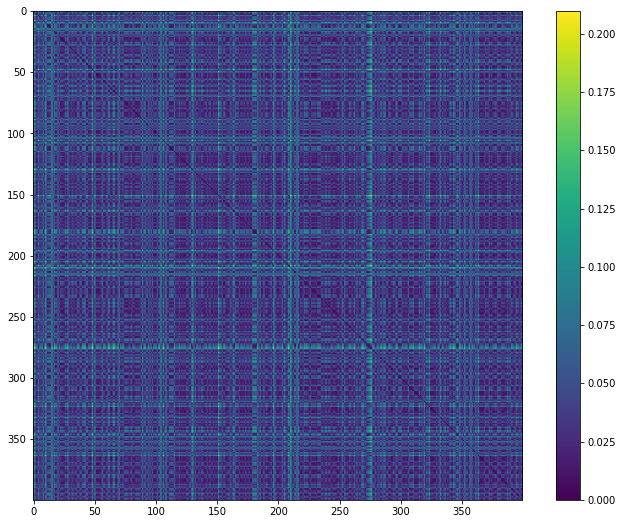

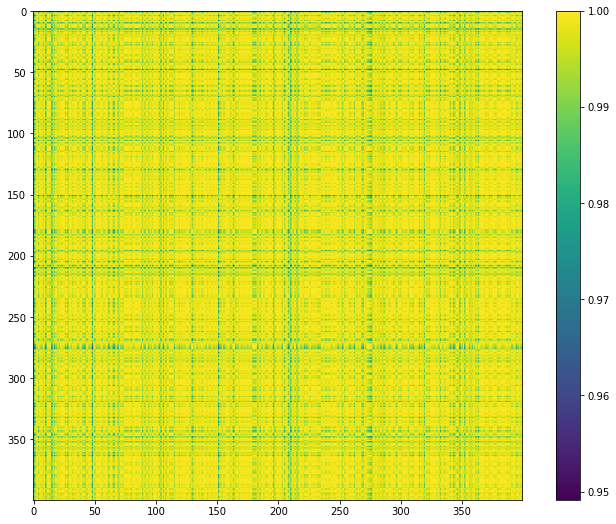

In [46]:
plot_C(C_full)

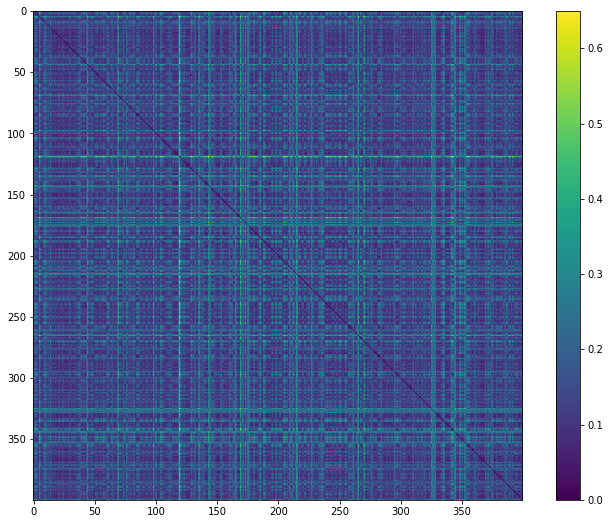

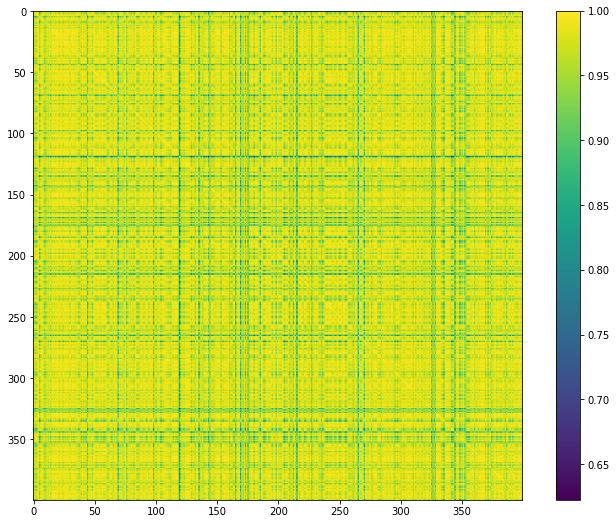

In [47]:
plot_C(C_inv)